In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
! pip3 install Keras-Applications

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, imsave
from skimage.transform import resize

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.2 MB/s 


In [3]:
epochs = 10       ### AP change
n=20              ### Number of images to analyse +1 !!!!   ### AP change
g_loss_min = 1000  ## initial generator loss

In [4]:
#########################################################################

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications.vgg19 import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################

['im1915.jpg', 'im1979.jpg', 'im1922.jpg', 'im1936.jpg', 'im1944.jpg', 'im1901.jpg', 'im1947.jpg', 'im1967.jpg', 'im1966.jpg', 'im1914.jpg', 'im1971.jpg', 'im1903.jpg', 'im1973.jpg', 'im2000.jpg', 'im1996.jpg', 'im1997.jpg', 'im1998.jpg', 'im1999.jpg', 'im1955.jpg', 'im1950.jpg']
['im1915.jpg', 'im1979.jpg', 'im1922.jpg', 'im1936.jpg', 'im1944.jpg', 'im1901.jpg', 'im1947.jpg', 'im1967.jpg', 'im1966.jpg', 'im1914.jpg', 'im1971.jpg', 'im1903.jpg', 'im1973.jpg', 'im2000.jpg', 'im1996.jpg', 'im1997.jpg', 'im1998.jpg', 'im1999.jpg', 'im1955.jpg', 'im1950.jpg']
(20, 32, 32, 3)
(20, 128, 128, 3)


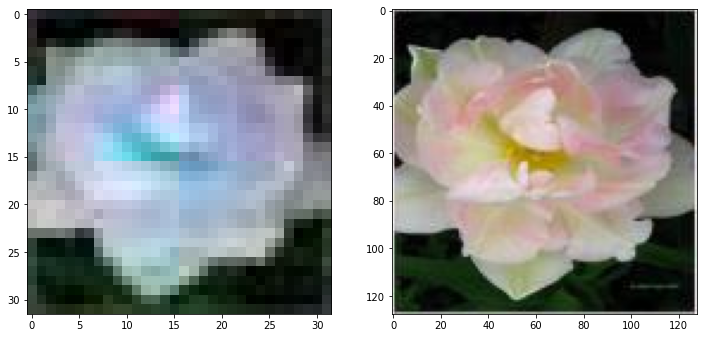

In [5]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images

lr_list = os.listdir("/content/drive/My Drive/Colab Notebooks/HighRes_SRGAN/Standardjpg/data/lr_images/")[:n]
print(lr_list)

lr_images = []
for img in sorted(lr_list):
    if img == ".ipynb_checkpoints":
      print(img)
    else:
      #print("hello", img)
      img_lr = imread("/content/drive/My Drive/Colab Notebooks/HighRes_SRGAN/Standardjpg/data/lr_images/" + img)
      img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)   ### AP change. this is not used because images already in RGB
      lr_images.append(img_lr)   
      #print(img_lr.shape)

hr_list = os.listdir("/content/drive/My Drive/Colab Notebooks/HighRes_SRGAN/Standardjpg/data/hr_images/")[:n]
print(hr_list)
hr_images = []
for img1 in sorted(hr_list):
    if img1 == ".ipynb_checkpoints":
      print(img)
    else:
      #print("hello", img1)
      img_hr = cv2.imread("/content/drive/My Drive/Colab Notebooks/HighRes_SRGAN/Standardjpg/data/hr_images/" + img1)
      img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)   ### AP change
      hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)
print(lr_images.shape)
print(hr_images.shape)

#Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
#plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.imshow(lr_images[image_number])
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [7]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.1, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
#generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
#discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1      ### AP change
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    if g_loss < g_loss_min :                         #AP
      generator.save("gen_e_"+ str(e+1) +".h5")      #AP
      g_loss_min = g_loss                            #AP
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

80150528/80134624 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                            

100%|██████████| 18/18 [00:27<00:00,  1.51s/it]


epoch: 1 g_loss: 230.89161258273654 d_loss: [15.79486162  0.63888889]


100%|██████████| 18/18 [00:02<00:00,  6.44it/s]


epoch: 2 g_loss: 109.19944466484918 d_loss: [14.65614226  0.52777778]


100%|██████████| 18/18 [00:03<00:00,  5.16it/s]


epoch: 3 g_loss: 101.21593178643121 d_loss: [7.74562524 0.69444444]


100%|██████████| 18/18 [00:02<00:00,  6.55it/s]


epoch: 4 g_loss: 93.14149326748318 d_loss: [3.6205542  0.72222222]


100%|██████████| 18/18 [00:02<00:00,  6.59it/s]


epoch: 5 g_loss: 90.85873052808974 d_loss: [3.90951462 0.77777778]


100%|██████████| 18/18 [00:02<00:00,  6.63it/s]


epoch: 6 g_loss: 87.77229521009657 d_loss: [1.07727834 0.91666667]


100%|██████████| 18/18 [00:02<00:00,  6.56it/s]


epoch: 7 g_loss: 80.06843948364258 d_loss: [1.05651103 0.94444444]


100%|██████████| 18/18 [00:02<00:00,  6.56it/s]


epoch: 8 g_loss: 75.41607771979437 d_loss: [0.28481223 0.94444444]


100%|██████████| 18/18 [00:02<00:00,  6.68it/s]


epoch: 9 g_loss: 71.35778511895074 d_loss: [1.66642794 0.75      ]


100%|██████████| 18/18 [00:02<00:00,  6.59it/s]


epoch: 10 g_loss: 67.15685907999675 d_loss: [1.44476356 0.83333333]


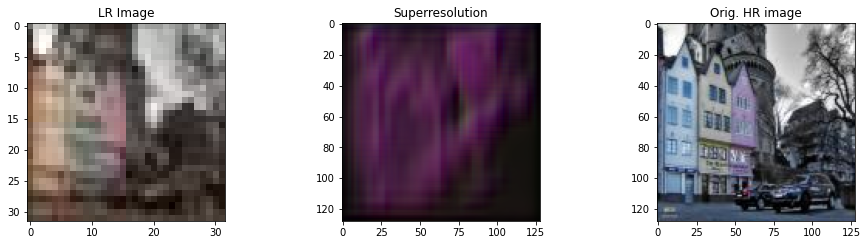

[1]


In [10]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

#generator = load_model('/content/drive/My Drive/Colab Notebooks/HighRes_SRGAN/Standardjpg/generator/gen_e_20.h5', compile=False)   ### AP change name of file
generator = load_model('gen_e_5.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
#ix=[101]    # AP  insert this only if we want one specific image 
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

#ix=101     # AP  insert this only if we want one specific image    
print(ix)
imsave('lr%.2f.jpg'%ix, src_image[0,:,:,:])
imsave('gen_image%.2f.jpg'%ix, gen_image[0,:,:,:])
imsave('hr3%.2f.jpg'%ix, tar_image[0,:,:,:])

################################################